In [1]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings(action='ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # Melspectrogram 벡터를 추출할 개수
    'SEED':42
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [5]:
train_df['label'].value_counts()

# 0: angry
# 1: fear
# 2: sad
# 3: disgust
# 4: neutral
# 5: happy

0    867
2    859
5    853
3    852
1    848
4    722
Name: label, dtype: int64

In [14]:
# features = []
# path = train_df['path'][0]
        
# y, sr = librosa.load(path, sr=CFG['SR'])
# y = list(y)
# y.extend([0 for _ in range(80000-len(y))])
# features.append(y)

# len(y)

In [9]:
def get_feature_mel(df):
    features = []
    for i in tqdm(df['path']):
        # i = '/content/drive/MyDrive/hi/sound01'+i[1:]
        data, sr = librosa.load(i, sr=CFG['SR'])
        n_fft = 2048
        win_length = 2048
        hop_length = 1024
        n_mels = 128
 
        D = np.abs(librosa.stft(data, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
        mel = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

        m_mel = mel.mean(axis=1)
        features.append(m_mel)
    return np.array(features)

train_mel = get_feature_mel(train_df)


  0%|          | 0/5001 [00:00<?, ?it/s]

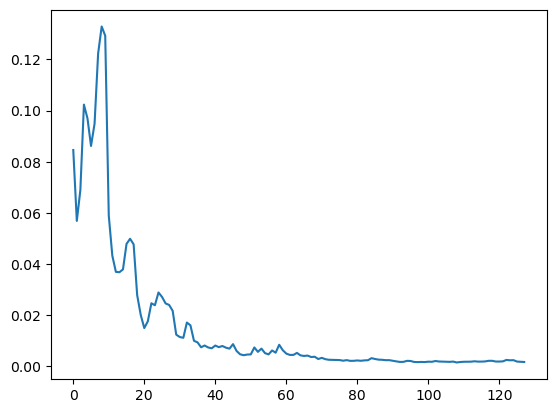

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_mel[0])

In [6]:
def get_mfcc_feature(df):
    features = []
#     for path in tqdm(df['path']):
        
#         y, sr = librosa.load(path, sr=CFG['SR'])
#         y = list(y)
#         y.extend([0 for _ in range(80100-len(y))])
#         features.append(y)
    for path in tqdm(df['path']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features
    # return pd.DataFrame(features,columns=['freq'])

vector = get_mfcc_feature(train_df)
test = get_mfcc_feature(test_df)

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

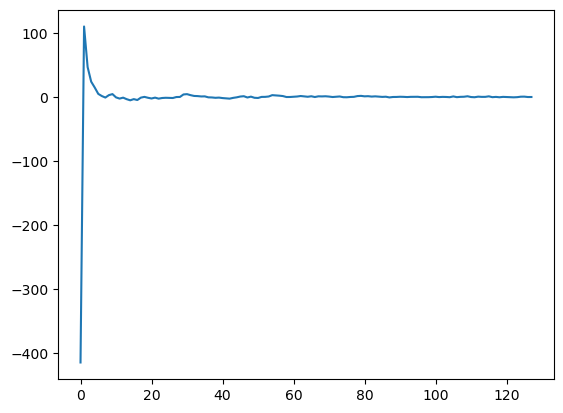

In [14]:
plt.plot(vector[0])

In [ ]:
# train_df[train_df['label'] == 0].index

In [15]:
# from sklearn.decomposition import PCA
# pca 

# pd.DataFrameFrame(vector.iloc[])

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
0,0.007507,0.008209,0.007935,0.008270,0.009094,0.009125,0.009491,0.009735,0.009216,0.010468,...,0,0,0,0,0,0,0,0,0,0
1,-0.004639,-0.005249,-0.005707,-0.006195,-0.006500,-0.006287,-0.005981,-0.005615,-0.004944,-0.004120,...,0,0,0,0,0,0,0,0,0,0
2,0.007721,0.006958,0.006714,0.006287,0.005890,0.005035,0.005035,0.004883,0.004211,0.005035,...,0,0,0,0,0,0,0,0,0,0
3,0.005859,0.005859,0.006073,0.006226,0.005829,0.005798,0.005768,0.005432,0.005524,0.004517,...,0,0,0,0,0,0,0,0,0,0
4,-0.006683,-0.006165,-0.004974,-0.004822,-0.004700,-0.003418,-0.003418,-0.003174,-0.002350,-0.002075,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.005157,0.004822,0.004883,0.005127,0.004456,0.004822,0.005157,0.005463,0.005920,0.005737,...,0,0,0,0,0,0,0,0,0,0
4997,0.008667,0.009064,0.008453,0.008026,0.008820,0.008453,0.007843,0.007660,0.006439,0.006744,...,0,0,0,0,0,0,0,0,0,0
4998,-0.003754,-0.003784,-0.004639,-0.003876,-0.003754,-0.004272,-0.004425,-0.005005,-0.004272,-0.004822,...,0,0,0,0,0,0,0,0,0,0
4999,-0.005341,-0.006104,-0.005371,-0.006805,-0.007233,-0.007355,-0.008087,-0.008392,-0.008942,-0.009308,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=600)
pca.fit(vector)
# target = pd.DataFrame(pca.transform(vector))
# target.to_csv('./origin_600_pca.csv')

PCA(n_components=600)

In [13]:
import numpy as np
max([len(i) for i in test])

80080

In [21]:
test = pd.DataFrame(pca.transform(test))
test.to_csv('./test_600_pca.csv')

print(sum(pca.explained_variance_ratio_))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1881,) + inhomogeneous part.

In [56]:
target = pd.read_csv('./origin_600_pca.csv')
conc = pd.DataFrame([list(reversed(list(target.iloc[i,:]))) for i in range(len(target))])

In [57]:
conc = conc.rename(columns={i:f'pca_{i}' for i in range(600)})
target = target.rename(columns={f'{i}':f'pca_{i}' for i in range(600)}).drop('Unnamed: 0',axis=1)

In [58]:
target = pd.concat([target,conc])
target

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_591,pca_592,pca_593,pca_594,pca_595,pca_596,pca_597,pca_598,pca_599,600
0,-0.021385,-0.012949,-0.015279,-0.011877,-0.025111,0.009895,-0.004037,-0.033308,0.008773,-0.014967,...,-0.021627,0.009855,0.002213,-0.011496,-0.020011,0.005312,-0.015379,-0.011613,-0.010847,NaN
1,0.000776,-0.021042,-0.005029,-0.016736,-0.010840,0.002814,-0.008290,-0.016119,-0.025994,-0.004446,...,-0.002577,0.012465,-0.003917,-0.002894,-0.017801,-0.007558,-0.012204,0.038600,-0.011025,NaN
2,0.052751,-0.054740,0.227633,0.128646,0.051232,0.086255,0.112322,-0.093411,-0.011321,-0.141729,...,-0.227377,0.047490,-0.014826,0.002115,0.098491,-0.055566,-0.131283,0.103348,0.003722,NaN
3,-0.002264,-0.053758,-0.065805,0.123830,-0.039335,-0.074199,0.080589,-0.034714,-0.094504,0.037295,...,0.246421,-0.030732,-0.010940,-0.126216,-0.159515,-0.083252,-0.060753,0.230066,-0.048657,NaN
4,0.012149,-0.100497,-0.033590,-0.113659,-0.128520,0.049028,-0.172694,-0.074595,0.006177,-0.125284,...,-0.055523,-0.011672,-0.177221,-0.020595,-0.111046,0.211206,0.203578,0.103752,-0.055185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,-0.042877,-0.006561,-0.053777,-0.060315,-0.113231,0.025670,-0.042992,-0.027823,0.031745,0.033578,...,-0.062950,0.028914,0.007278,0.021489,0.004603,0.027164,-0.033432,-0.003941,0.004596,4996.0
4997,-0.110533,0.090996,0.126189,-0.044549,0.112800,-0.046879,-0.038362,-0.013591,-0.098096,0.214015,...,-1.044811,0.535062,-0.007586,-1.326804,-1.387200,-0.482458,-0.340060,-0.451134,-0.048009,4997.0
4998,-0.166486,0.070321,0.038598,-0.022319,-0.027345,0.090069,-0.003661,0.055641,-0.104162,-0.005171,...,0.005387,-0.079840,0.028089,0.177551,-0.074893,-0.156975,0.098310,-0.082456,0.011474,4998.0
4999,-0.052966,0.044866,0.057982,0.035652,0.082762,-0.037150,0.041298,-0.040216,-0.000206,-0.048188,...,0.010496,-0.027867,0.025754,-0.044363,-0.007708,-0.009071,-0.006900,-0.049939,-0.021732,4999.0
